<a href="https://colab.research.google.com/github/ApoorvaNagarajan/Image-Filter-Kernels/blob/master/assignment14/assignment14.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import time, math
from tqdm import tqdm_notebook as tqdm

import tensorflow as tf
import tensorflow.contrib.eager as tfe
import matplotlib.pyplot as plt 

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [0]:
tf.enable_eager_execution()


In [0]:
from google.colab import drive
import time, math

In [4]:
!rm -rf DNN_utils
!git clone https://github.com/ApoorvaNagarajan/DNN_utils.git

from DNN_utils import tfrecord_utils
from DNN_utils import data_transforms as dt

Cloning into 'DNN_utils'...
remote: Enumerating objects: 78, done.
remote: Counting objects: 100% (78/78), done.
remote: Compressing objects: 100% (76/76), done.
remote: Total 144 (delta 36), reused 0 (delta 0), pack-reused 66
Receiving objects: 100% (144/144), 55.61 KiB | 593.00 KiB/s, done.
Resolving deltas: 100% (59/59), done.


Using TensorFlow backend.


In [5]:
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
BATCH_SIZE = 512 #@param {type:"integer"}
MOMENTUM = 0.9 #@param {type:"number"}
LEARNING_RATE = 1 #@param {type:"number"}
WEIGHT_DECAY = 5e-4 #@param {type:"number"}
EPOCHS = 30 #@param {type:"integer"}

In [0]:
#Configuration

NUM_CLASSES = 10 
IMG_SHAPE=[32, 32, 3]
NUM_TRAIN_IMG = 50000
NUM_TEST_IMG = 10000
BATCHES_PER_EPOCH = NUM_TRAIN_IMG//BATCH_SIZE
VALIDATION_STEPS = NUM_TEST_IMG//BATCH_SIZE

In [0]:
tfrecord_utils.convert_to_tfRecord('CIFAR10',trainFile='/content/drive/My Drive/datasets/cifarTfTrain.tfrecords', testFile='/content/drive/My Drive/datasets/cifarTfTest.tfrecords')
train_x, train_y = tfrecord_utils.parse_tfRecord_plain('/content/drive/My Drive/datasets/cifarTfTrain.tfrecords', NUM_TRAIN_IMG, IMG_SHAPE)
test_x, test_y = tfrecord_utils.parse_tfRecord_plain('/content/drive/My Drive/datasets/cifarTfTest.tfrecords', NUM_TEST_IMG, IMG_SHAPE)

In [0]:
train_mean = tf.keras.backend.mean(train_x, axis=(0,1,2))
train_std = tf.keras.backend.std(train_x, axis=(0,1,2))

normalize = lambda x: ((x - train_mean) / train_std) # todo: check here
pad4 = lambda x: tf.pad(x, [(0, 0), (4, 4), (4, 4), (0, 0)], mode='reflect')

train_x = normalize(pad4(train_x))
test_x = normalize(test_x)

train_y = tf.cast(train_y, dtype='int64')
test_y = tf.cast(test_y, dtype='int64')

In [0]:
test_set = tf.data.Dataset.from_tensor_slices((test_x, test_y))
train_set = tf.data.Dataset.from_tensor_slices((train_x, train_y))

In [0]:
def init_pytorch(shape, dtype=tf.float32, partition_info=None):
  fan = np.prod(shape[:-1])
  bound = 1 / math.sqrt(fan)
  return tf.random.uniform(shape, minval=-bound, maxval=bound, dtype=dtype)

In [0]:
class ConvBN(tf.keras.Model):
  def __init__(self, c_out):
    super().__init__()
    self.conv = tf.keras.layers.Conv2D(filters=c_out, kernel_size=3, padding="SAME", kernel_initializer=init_pytorch, use_bias=False)
    self.bn = tf.keras.layers.BatchNormalization(momentum=0.9, epsilon=1e-5)

  def call(self, inputs):
    return tf.nn.relu(self.bn(self.conv(inputs)))

In [0]:
class ResBlk(tf.keras.Model):
  def __init__(self, c_out, pool, res = False):
    super().__init__()
    self.conv_bn = ConvBN(c_out)
    self.pool = pool
    self.res = res
    if self.res:
      self.res1 = ConvBN(c_out)
      self.res2 = ConvBN(c_out)

  def call(self, inputs):
    h = self.pool(self.conv_bn(inputs))
    if self.res:
      h = h + self.res2(self.res1(h))
    return h

In [0]:
class DavidNet(tf.keras.Model):
  def __init__(self, c=64, weight=0.125):
    super().__init__()
    pool = tf.keras.layers.MaxPooling2D()
    self.init_conv_bn = ConvBN(c)
    self.blk1 = ResBlk(c*2, pool, res = True)
    self.blk2 = ResBlk(c*4, pool)
    self.blk3 = ResBlk(c*8, pool, res = True)
    self.pool = tf.keras.layers.GlobalMaxPool2D()
    self.linear = tf.keras.layers.Dense(10, kernel_initializer=init_pytorch, use_bias=False)
    self.weight = weight

  def call(self, x, y):
    h = self.pool(self.blk3(self.blk2(self.blk1(self.init_conv_bn(x)))))
    h = self.linear(h) * self.weight
    ce = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=h, labels=y)
    loss = tf.reduce_sum(ce)
    correct = tf.reduce_sum(tf.cast(tf.math.equal(tf.argmax(h, axis = 1), y), tf.float32))
    return loss, correct

In [0]:
model = DavidNet()

batches_per_epoch = NUM_TRAIN_IMG//BATCH_SIZE + 1

lr_schedule = lambda t: np.interp([t], [0, (EPOCHS+1)//5, int((EPOCHS+1)*0.8),EPOCHS], [LEARNING_RATE/5, LEARNING_RATE, LEARNING_RATE/10, 0.01])[0]
global_step = tf.train.get_or_create_global_step()
lr_func = lambda: lr_schedule(global_step/batches_per_epoch)/BATCH_SIZE
opt = tf.train.MomentumOptimizer(lr_func, momentum=MOMENTUM, use_nesterov=True)
data_aug = lambda x, y: (tf.image.random_crop(tf.image.random_flip_left_right(dt.cutOut(x,8,8,0,1)), IMG_SHAPE),y)

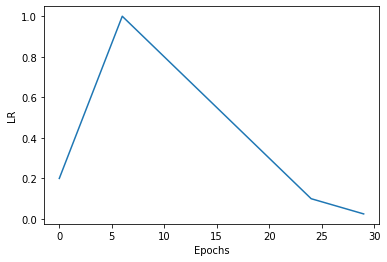

In [16]:
#plot learning rate scheduler

epoch_num = []
lr_val = []
for i in range(EPOCHS):
    epoch_num.append(i)
    lr_val.append(lr_schedule(i))

plt.plot(epoch_num, lr_val) 
plt.xlabel('Epochs') 
plt.ylabel('LR') 
plt.show() 

In [17]:
t = time.time()
test_set_1 = test_set.batch(BATCH_SIZE)

for epoch in range(EPOCHS):
  train_loss = test_loss = train_acc = test_acc = 0.0
  train_set_aug = train_set.map(data_aug).shuffle(NUM_TRAIN_IMG).batch(BATCH_SIZE).prefetch(1)

  tf.keras.backend.set_learning_phase(1)
  for (x, y) in tqdm(train_set_aug):
    with tf.GradientTape() as tape:
      loss, correct = model(x, y)

    var = model.trainable_variables
    grads = tape.gradient(loss, var)
    for g, v in zip(grads, var):
      g += v * WEIGHT_DECAY * BATCH_SIZE
    opt.apply_gradients(zip(grads, var), global_step=global_step)

    train_loss += loss.numpy()
    train_acc += correct.numpy()

  tf.keras.backend.set_learning_phase(0)
  for (x, y) in test_set_1:
    loss, correct = model(x, y)
    test_loss += loss.numpy()
    test_acc += correct.numpy()
    
  print('epoch:', epoch+1, 'lr:', lr_schedule(epoch+1), 'train loss:', train_loss / NUM_TRAIN_IMG, 'train acc:', train_acc / NUM_TRAIN_IMG, 'val loss:', test_loss / NUM_TEST_IMG, 'val acc:', test_acc / NUM_TEST_IMG, 'time:', time.time() - t)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



epoch: 1 lr: 0.33333333333333337 train loss: 1.4823415765380858 train acc: 0.45438 val loss: 1.7728966705322267 val acc: 0.4572 time: 34.44650888442993



epoch: 2 lr: 0.4666666666666667 train loss: 0.9417958587646484 train acc: 0.6689 val loss: 0.8589037872314453 val acc: 0.6969 time: 63.024739265441895



epoch: 3 lr: 0.6000000000000001 train loss: 0.7354410418701172 train acc: 0.74344 val loss: 0.6313902633666992 val acc: 0.7808 time: 91.16496586799622



epoch: 4 lr: 0.7333333333333334 train loss: 0.6090265924072266 train acc: 0.79044 val loss: 0.7051972351074218 val acc: 0.7672 time: 119.37249684333801



epoch: 5 lr: 0.8666666666666667 train loss: 0.5289093301391602 train acc: 0.81704 val loss: 0.803522917175293 val acc: 0.7292 time: 147.41888189315796



epoch: 6 lr: 1.0 train loss: 0.44968866943359376 train acc: 0.84188 val loss: 0.5807058410644531 val acc: 0.8069 time: 175.3611261844635



epoch: 7 lr: 0.95 train loss: 0.40134485595703123 train acc: 0.86076 val loss: 0.4849019119262695 val acc: 0.8381 time: 203.33996844291687



epoch: 8 lr: 0.9 train loss: 0.3492153713989258 train acc: 0.8773 val loss: 0.45336585998535156 val acc: 0.8517 time: 231.2734797000885



epoch: 9 lr: 0.85 train loss: 0.3068003401184082 train acc: 0.8925 val loss: 0.42669003448486326 val acc: 0.8657 time: 259.1677107810974



epoch: 10 lr: 0.8 train loss: 0.26461593048095705 train acc: 0.9081 val loss: 0.36808995208740236 val acc: 0.8789 time: 286.9471654891968



epoch: 11 lr: 0.75 train loss: 0.24071693572998046 train acc: 0.91664 val loss: 0.3571105438232422 val acc: 0.8833 time: 314.9842314720154



epoch: 12 lr: 0.7 train loss: 0.22051381820678712 train acc: 0.92276 val loss: 0.3908932411193848 val acc: 0.8792 time: 342.91675329208374



epoch: 13 lr: 0.6499999999999999 train loss: 0.19780623336791991 train acc: 0.93078 val loss: 0.31127082977294923 val acc: 0.9022 time: 370.85307598114014



epoch: 14 lr: 0.6 train loss: 0.1740492526245117 train acc: 0.93938 val loss: 0.3413909553527832 val acc: 0.8903 time: 398.82975721359253



epoch: 15 lr: 0.55 train loss: 0.1587451919555664 train acc: 0.94436 val loss: 0.3082832931518555 val acc: 0.9033 time: 426.8961069583893



epoch: 16 lr: 0.5 train loss: 0.14165781455993653 train acc: 0.95122 val loss: 0.2834861053466797 val acc: 0.9137 time: 454.9461193084717



epoch: 17 lr: 0.44999999999999996 train loss: 0.12582446380615234 train acc: 0.95652 val loss: 0.2934601280212402 val acc: 0.9069 time: 483.0159296989441



epoch: 18 lr: 0.3999999999999999 train loss: 0.10775788803100586 train acc: 0.96222 val loss: 0.26756296005249025 val acc: 0.9188 time: 511.17708373069763



epoch: 19 lr: 0.35 train loss: 0.09968965293884277 train acc: 0.96512 val loss: 0.2816333137512207 val acc: 0.9167 time: 539.5033085346222



epoch: 20 lr: 0.29999999999999993 train loss: 0.08736301681518555 train acc: 0.96974 val loss: 0.2623937316894531 val acc: 0.9225 time: 567.6838974952698



epoch: 21 lr: 0.25 train loss: 0.07392616565704346 train acc: 0.97408 val loss: 0.25257853012084963 val acc: 0.9231 time: 595.8542323112488



epoch: 22 lr: 0.19999999999999996 train loss: 0.06673388172149658 train acc: 0.97684 val loss: 0.24529243545532226 val acc: 0.9293 time: 623.9681851863861



epoch: 23 lr: 0.1499999999999999 train loss: 0.05909115528106689 train acc: 0.97976 val loss: 0.24614822006225587 val acc: 0.9299 time: 652.3263895511627



epoch: 24 lr: 0.1 train loss: 0.05095312406539917 train acc: 0.98262 val loss: 0.2401236801147461 val acc: 0.932 time: 680.4055454730988



epoch: 25 lr: 0.085 train loss: 0.04776399856567383 train acc: 0.98402 val loss: 0.23575886917114258 val acc: 0.9322 time: 708.6199951171875



epoch: 26 lr: 0.07 train loss: 0.045130267391204834 train acc: 0.985 val loss: 0.23587980270385742 val acc: 0.9335 time: 736.9000918865204



epoch: 27 lr: 0.055 train loss: 0.04109972049713135 train acc: 0.98622 val loss: 0.2334308780670166 val acc: 0.9338 time: 765.1374001502991



epoch: 28 lr: 0.04 train loss: 0.042188811683654785 train acc: 0.98576 val loss: 0.2347412612915039 val acc: 0.9352 time: 793.4591765403748



epoch: 29 lr: 0.024999999999999994 train loss: 0.036409507217407225 train acc: 0.98852 val loss: 0.23317779998779298 val acc: 0.9359 time: 821.7264485359192



epoch: 30 lr: 0.01 train loss: 0.03677791883468628 train acc: 0.98846 val loss: 0.23183784408569336 val acc: 0.9362 time: 850.0841374397278
